## 项目背景

此项目用于某品牌的某ID单品销量预测

此项目选用XGB模型对销量进行回归预测,未进行模型融合.

评判标准有三种,分别是MAE(预测与实际的销量差额绝对值平均数),单天预测准确率,整体预测差异率,计算方法如下

$$
MAE = \frac{1}{m}\sum_{}^{m}(\left| y-\hat{y} \right|)
$$

$$
单天预测准确率 = 1-\frac{1}{m}\sum_{}^{m}\frac{\left| y-\hat{y} \right|}{y}
$$

$$
整体预测差异率 = 1-\frac{\sum_{}^{m}y-\sum_{}^{m}\hat{y}}{\sum_{}^{m}y}
$$


## 最终结果如下表

| 数据集名称 | MAE | 单天预测差异率 | 整体预测差异率 |
|:------|:---:|:-------:|:-------:|
| 验证集   | 479 | 65.35%  | 99.41%  |
| 测试集   | 285 | 58.10%  | 97.23%  |

单天预测绝对值差异较大的数据主要集中在大促时间点附近,一方面是大促的数据较少,模型不能很好的预测,另一方面也有每年大促玩法,力度不同的原因.(为对抗第二种情况,引入人工tag**活动强度**,由业务同学手动填写)

单天预测差异率较大的数据主要是实际数据较小,差异绝对值不大,但差异率较大,拉高了整体的预测差异率

模型结果无明显差异,泛化性较好.



## 过程
此项目原始提供**时间,商品ID,销售金额,销量, 客单价,当天价格,加购**字段

添加**年,月,日,周,季,周几**等字段字段

尝试添加 **前一天销售金额,前一周销售金额,前十五天销售金额,前三十天销售金额,前一天加购人数,前一周加购人数,前十五天加购人数,前三十天加购人数**字段,但结果显示为负收益

舍弃 销售金额,客单价,加购 字段(实际业务中并不能获取到)

因销量字段大促期和平销期差距过大,做对数处理

通过三次随机网格搜索,分别测试,选出最佳超参数






In [1]:
import os
import time
import datetime
import json

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost

import matplotlib.pyplot as plt

D:\workspace\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def load_active_days(names):
    # 加载活动数据
    datas = []
    for i in names:
        with open(i, 'r', encoding='utf-8') as f:
            s1 = json.loads(f.read())
            data = s1['data']
            datas.extend(data)
    active_days_df = pd.DataFrame().from_dict(s1['data'])

    # 时间戳类型列转日期
    time_cols_list = [
        'activityStart', 'preheatStart', 'preheatEnd', 'ORDER_BY_TIME',
        'activityEnd'
    ]
    for time_col in time_cols_list:
        active_days_df[time_col] = active_days_df[time_col].apply(
            lambda x: pd.to_datetime(x, unit='ms') + pd.Timedelta(days=8 / 24))
    # 转换类型
    return active_days_df


def date_col_split(df, date_col_name):
    # 时间列拆分
    weekday2num = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    df['year'] = df[date_col_name].dt.year
    df['month'] = df[date_col_name].dt.month
    df['day'] = df[date_col_name].dt.day
    df['week'] = df[date_col_name].dt.isocalendar().week
    df['week'] = df['week'].astype('int')
    df['quarter'] = df[date_col_name].dt.quarter
    df['day_of_week'] = df[date_col_name].dt.day_name()
    df['day_of_week'] = df['day_of_week'].map(weekday2num)

In [6]:
# def MAE(predict_log_data_tuple,real_data_tuple):
#     length = predict_log_data_tuple.shape[0]
#     error_sum = 0
#     data_list = []
#     real_data_list = list(real_data_tuple)
#     for log_data in predict_log_data_tuple:
#         data = np.exp(log_data)-1
#         data_list.append(data)
#     for num in range(length):
#         basal = max(data_list[num],real_data_list[num])
#         if basal ==0:
#             basal = 1
#         error = (abs(data_list[num]-real_data_list[num])/basal)**2
#         error_sum+=error
#     rmse = 1-np.sqrt(error_sum/(length+1))
#     return rmse,data_list,real_data_list

In [7]:
def days_of_2019(date):
    if date > pd.to_datetime('20210301'):
        return_date = date + datetime.timedelta(days=-730)
    else:
        return_date = date + datetime.timedelta(days=-731)
    return return_date

## 读取活动日历

In [8]:
names = ['飞利浦活动日历-2021.txt']
active_days_df = load_active_days(names)

# platformActivityId 的空值由activityId填补
active_days_df.loc[active_days_df['platformActivityId'].isna(),
                   'platformActivityId'] = active_days_df.loc[
                       active_days_df['platformActivityId'].isna(),
                       'activityId']
# 删除活动等级为S,活动类型为2的 (这些都是预售)
active_days_df.drop(
    active_days_df[(active_days_df['activityFlag'] == 'S')
                   & (active_days_df['activityMode'] == 2)].index,
    inplace=True)

In [9]:
active_days_2019_df = active_days_df.copy(deep=True)
active_days_2020_df = active_days_df.copy(deep=True)

In [10]:
active_days_2020_df['activityStart'] = active_days_2020_df['activityStart'] + \
    datetime.timedelta(days=-365)
active_days_2019_df['activityStart'] = active_days_2019_df[
    'activityStart'].apply(days_of_2019)
active_days_2020_df['activityEnd'] = active_days_2020_df['activityEnd'] + \
    datetime.timedelta(days=-365)
active_days_2019_df['activityEnd'] = active_days_2019_df['activityEnd'].apply(
    days_of_2019)
active_days_2020_df['ORDER_BY_TIME'] = active_days_2020_df['ORDER_BY_TIME'] + \
    datetime.timedelta(days=-365)
active_days_2019_df['ORDER_BY_TIME'] = active_days_2019_df[
    'ORDER_BY_TIME'].apply(days_of_2019)

In [11]:
active_days_df = pd.concat(
    [active_days_df, active_days_2019_df, active_days_2020_df])

In [12]:
flp_sales_source_data_df = pd.read_excel('./6730sku_predict.xlsx')
flp_sales_source_data_df

,Date,SKU,Store,Sales,Qty,ASP,客单价,Shopping Cart,宝贝名称,URL地址,活动强度
0,20190101,HX6730,飞利浦官方旗舰店,222171.50,551,403.215064,447.025151,1652.0,飞利浦电动牙刷HX6730/6721成人充电式声波震动电动牙刷智能净白,http://detail.tmall.com/item.htm?id=13230519823,2
1,20190102,HX6730,飞利浦官方旗舰店,17736.00,44,403.090909,454.769231,1828.0,飞利浦电动牙刷HX6730/6721成人充电式声波震动电动牙刷智能净白,http://detail.tmall.com/item.htm?id=13230519823,2
2,20190103,HX6730,飞利浦官方旗舰店,451025.41,1132,398.432341,444.798235,2225.0,飞利浦电动牙刷HX6730/6721成人充电式声波震动电动牙刷智能净白,http://detail.tmall.com/item.htm?id=13230519823,2
3,20190104,HX6730,飞利浦官方旗舰店,280162.60,703,398.524324,448.260160,1871.0,飞利浦电动牙刷HX6730/6721成人充电式声波震动电动牙刷智能净白,http://detail.tmall.com/item.htm?id=13230519823,2
4,20190105,HX6730,飞利浦官方旗舰店,195976.56,487,402.415934,437.447679,1768.0,飞利浦电动牙刷HX6730/6721成人充电式声波震动电动牙刷智能净白,http://detail.tmall.com/item.htm?id=13230519823,2
...,...,...,...,...,...,...,...,...,...,...,...
1091,20211227,HX6730,飞利浦官方旗舰店,163671.00,519,315.358382,353.501080,NaN,飞利浦电动牙刷HX6730/HX7082成人充电声波震动电动牙刷智能净白,NaN,2
1092,20211228,HX6730,飞利浦官方旗舰店,105364.00,336,313.583333,343.205212,NaN,飞利浦电动牙刷HX6730/HX7083成人充电声波震动电动牙刷智能净白,NaN,2
1093,20211229,HX6730,飞利浦官方旗舰店,78347.00,253,309.671937,329.189076,NaN,飞利浦电动牙刷HX6730/HX7084成人充电声波震动电动牙刷智能净白,NaN,2
1094,20211230,HX6730,飞利浦官方旗舰店,230168.36,726,317.036309,359.638062,NaN,飞利浦电动牙刷HX6730/HX7085成人充电声波震动电动牙刷智能净白,NaN,2


In [13]:
# active_days_df.to_excel('./flp_active.xlsx',index=None)

## 数据预处理

### 缺失值处理

In [14]:
flp_sales_source_data_df['Sales'] = flp_sales_source_data_df['Sales'].fillna(0)

flp_sales_source_data_df['Qty'].fillna(value=0, inplace=True)

flp_sales_source_data_df.loc[
    flp_sales_source_data_df['客单价'].isna(),
    '客单价'] = flp_sales_source_data_df[flp_sales_source_data_df['客单价'].isna(
    )]['Sales'] / flp_sales_source_data_df[
        flp_sales_source_data_df['客单价'].isna()]['Qty']
flp_sales_source_data_df['客单价'] = flp_sales_source_data_df['客单价'].fillna(0)

flp_sales_source_data_df.loc[
    flp_sales_source_data_df['ASP'].isna(),
    'ASP'] = flp_sales_source_data_df[flp_sales_source_data_df['ASP'].isna(
    )]['Sales'] / flp_sales_source_data_df[
        flp_sales_source_data_df['ASP'].isna()]['Qty']
flp_sales_source_data_df['ASP'] = flp_sales_source_data_df['ASP'].fillna(0)

flp_sales_source_data_df['Shopping Cart'].fillna(method='ffill', inplace=True)
flp_sales_source_data_df['URL地址'].fillna(method='ffill', inplace=True)

### 类型转换,构建数值列表和类别列表

In [15]:
flp_sales_source_data_df['Sales'] = flp_sales_source_data_df['Sales'].astype(
    int)
features = flp_sales_source_data_df.columns.to_list()
numerics = ['int16', 'int32', 'int64', 'float32', 'float64']
numeric_cols = flp_sales_source_data_df.select_dtypes(
    include=numerics).columns.to_list()
non_numeric_cols = [i for i in features if i not in numeric_cols]

In [16]:
non_numeric_cols

['SKU', 'Store', '宝贝名称', 'URL地址']

### 缺失值处理

In [17]:
flp_sales_source_data_df['Sales'] = flp_sales_source_data_df['Sales'].fillna(0)

flp_sales_source_data_df['Qty'].fillna(value=0, inplace=True)

flp_sales_source_data_df.loc[
    flp_sales_source_data_df['客单价'].isna(),
    '客单价'] = flp_sales_source_data_df[flp_sales_source_data_df['客单价'].isna(
    )]['Sales'] / flp_sales_source_data_df[
        flp_sales_source_data_df['客单价'].isna()]['Qty']
flp_sales_source_data_df['客单价'] = flp_sales_source_data_df['客单价'].fillna(0)

flp_sales_source_data_df.loc[
    flp_sales_source_data_df['ASP'].isna(),
    'ASP'] = flp_sales_source_data_df[flp_sales_source_data_df['ASP'].isna(
    )]['Sales'] / flp_sales_source_data_df[
        flp_sales_source_data_df['ASP'].isna()]['Qty']
flp_sales_source_data_df['ASP'] = flp_sales_source_data_df['ASP'].fillna(0)

flp_sales_source_data_df['Shopping Cart'].fillna(method='ffill', inplace=True)
flp_sales_source_data_df['URL地址'].fillna(method='ffill', inplace=True)

In [18]:
flp_sales_source_data_df.isna().sum()

Date             0
SKU              0
Store            0
Sales            0
Qty              0
ASP              0
客单价              0
Shopping Cart    0
宝贝名称             0
URL地址            0
活动强度             0
dtype: int64

In [19]:
flp_sales_source_data_df[flp_sales_source_data_df['Date'].duplicated()]

,Date,SKU,Store,Sales,Qty,ASP,客单价,Shopping Cart,宝贝名称,URL地址,活动强度


### 字符型编码

In [20]:
le = LabelEncoder()
for col in non_numeric_cols:
    le.fit(flp_sales_source_data_df[col])
    flp_sales_source_data_df[col] = le.transform(flp_sales_source_data_df[col])

(array([845., 139.,  40.,  19.,   6.,   4.,   6.,   6.,   4.,   3.,   3.,
          1.,   5.,   2.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,
          2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([     0.  ,   1273.37,   2546.74,   3820.11,   5093.48,   6366.85,
          7640.22,   8913.59,  10186.96,  11460.33,  12733.7 ,  14007.07,
         15280.44,  16553.81,  17827.18,  19100.55,  20373.92,  21647.29,
         22920.66,  24194.03,  25467.4 ,  26740.77,  28014.14,  29287.51,
         30560.88,  31

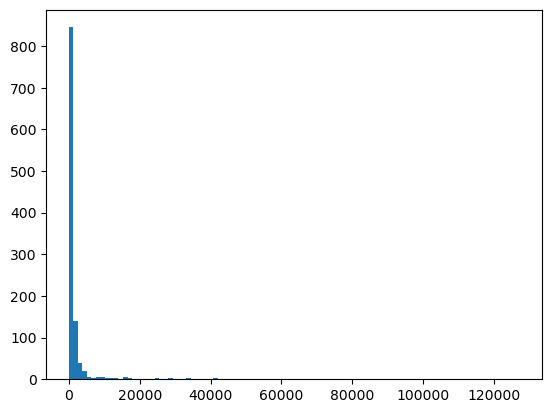

In [21]:
plt.hist(flp_sales_source_data_df['Qty'], bins=100)

(array([ 1.,  0.,  1.,  0.,  0.,  2.,  5.,  2.,  0.,  5.,  7.,  4., 10.,
         4.,  8.,  5., 12., 11., 20., 14., 17., 25., 29., 21., 31., 22.,
        25., 35., 37., 21., 32., 31., 23., 31., 24., 20., 17., 21., 12.,
         9.,  6.,  7.,  4.,  3.,  2.,  7.,  0.,  7.,  0., 67.,  0.,  0.,
         4.,  0.,  2.,  2.,  6.,  4.,  4.,  9.,  5., 11., 11.,  9., 25.,
        12., 18., 30., 20., 22., 20., 16., 12., 12., 11., 11.,  9., 10.,
         4.,  8., 11.,  7.,  5., 10., 11.,  6.,  5.,  3.,  6.,  6.,  5.,
         6.,  0.,  4.,  1.,  3.,  0.,  1.,  0.,  1.]),
 array([-11.74795016, -11.51292473, -11.2778993 , -11.04287388,
        -10.80784845, -10.57282303, -10.3377976 , -10.10277218,
         -9.86774675,  -9.63272133,  -9.3976959 ,  -9.16267047,
         -8.92764505,  -8.69261962,  -8.4575942 ,  -8.22256877,
         -7.98754335,  -7.75251792,  -7.5174925 ,  -7.28246707,
         -7.04744165,  -6.81241622,  -6.57739079,  -6.34236537,
         -6.10733994,  -5.87231452,  -5.63728909, 

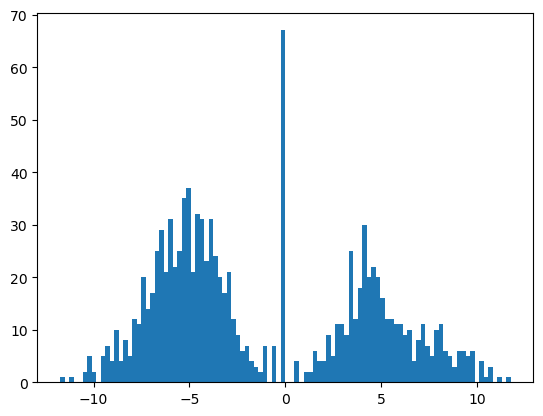

In [22]:
def log_if_not_0(num):
    if num == 0:
        return 0
    else:
        num = np.log(abs(num)) * (num / abs(num))
    return num


flp_sales_source_data_df['diff_Qty'] = flp_sales_source_data_df['Qty'].diff()
flp_sales_source_data_df['diff_Qty'] = flp_sales_source_data_df[
    'diff_Qty'].apply(log_if_not_0)
plt.hist(flp_sales_source_data_df['diff_Qty'], bins=100)

(array([95.,  0.,  0.,  0.,  0., 19.,  0.,  0.,  0.,  7.,  0.,  4.,  0.,
         0.,  0.,  2.,  0.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  5.,  5.,  2.,  2.,  4.,  7.,  4.,  1.,
         8.,  9.,  8.,  8., 11., 11., 13., 28., 24., 19., 22., 27., 36.,
        43., 59., 59., 64., 54., 64., 56., 37., 24., 29., 22., 26., 25.,
        20., 15., 13., 11., 10., 11.,  6.,  6.,  6.,  2.,  2.,  5.,  4.,
         4.,  6.,  3.,  1.,  6.,  2.,  0.,  0.,  2.,  3.,  2.,  0.,  3.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.117546  ,  0.235092  ,  0.35263801,  0.47018401,
         0.58773001,  0.70527601,  0.82282202,  0.94036802,  1.05791402,
         1.17546002,  1.29300603,  1.41055203,  1.52809803,  1.64564403,
         1.76319004,  1.88073604,  1.99828204,  2.11582804,  2.23337405,
         2.35092005,  2.46846605,  2.58601205,  2.70355806,  2.82110406,
         2.93865006,  3.05619606,  3.17374207,  3.29128807,  3.408834

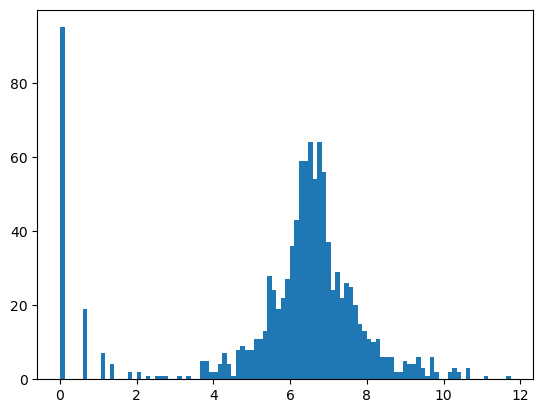

In [23]:
flp_sales_source_data_df['log_Qty'] = flp_sales_source_data_df['Qty'].apply(
    lambda x: np.log(x + 1))

plt.hist(flp_sales_source_data_df['log_Qty'], bins=100)

### 自建特征

In [24]:
# 时间列展开
flp_sales_source_data_df['Date'] = flp_sales_source_data_df['Date'].astype(str)
flp_sales_source_data_df['Date'] = flp_sales_source_data_df['Date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
date_col_split(flp_sales_source_data_df, 'Date')

In [25]:
# def is_active_day(date,active_days_df):
#     active_flag = 0
#     first_order_day= 0
#     S_level_flag = 0
#     special_day= 0
#     for index,row in active_days_df.iterrows():
#         if date >= row['activityStart'] and date <= row['activityEnd']:
#             active_flag = 1
#             if row['activityFlag'] =='S':
#                 S_level_flag = 1
#         if row['ORDER_BY_TIME'].to_pydatetime().date() == date.to_pydatetime().date():
#             first_order_day = 1
#
#     special_days = ['0308','0618','1111','1212']
#     years = ['2019','2020','2021','2022']
#     special_dates = []
#     for year in years:
#         for day in special_days:
#             special_date = year+day
#             special_timestamp = pd.to_datetime(special_date)
#             special_dates.append(special_timestamp)
#     if date in special_dates:
#         active_flag = 1
#         S_level_flag =1
#         first_order_day=1
#         special_day = 1
#     return (active_flag,S_level_flag,first_order_day,special_day)

In [26]:
# flp_sales_source_data_df['is_active'],flp_sales_source_data_df['is_S_level_active'],flp_sales_source_data_df['is_first_day_of_order'],flp_sales_source_data_df['is_special_day'] = zip(*flp_sales_source_data_df['Date'].apply(is_active_day,args=(active_days_df,)))

## 特征工程

In [27]:
flp_sales_source_data_df

,Date,SKU,Store,Sales,Qty,ASP,客单价,Shopping Cart,宝贝名称,URL地址,活动强度,diff_Qty,log_Qty,year,month,day,week,quarter,day_of_week
0,2019-01-01,0,0,222171,551,403.215064,447.025151,1652.0,0,0,2,NaN,6.313548,2019,1,1,1,1,2
1,2019-01-02,0,0,17736,44,403.090909,454.769231,1828.0,0,0,2,-6.228511,3.806662,2019,1,2,1,1,3
2,2019-01-03,0,0,451025,1132,398.432341,444.798235,2225.0,0,0,2,6.992096,7.032624,2019,1,3,1,1,4
3,2019-01-04,0,0,280162,703,398.524324,448.260160,1871.0,0,0,2,-6.061457,6.556778,2019,1,4,1,1,5
4,2019-01-05,0,0,195976,487,402.415934,437.447679,1768.0,0,0,2,-5.375278,6.190315,2019,1,5,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2021-12-27,0,0,163671,519,315.358382,353.501080,1330.0,362,1,2,4.442651,6.253829,2021,12,27,52,4,1
1092,2021-12-28,0,0,105364,336,313.583333,343.205212,1330.0,363,1,2,-5.209486,5.820083,2021,12,28,52,4,2
1093,2021-12-29,0,0,78347,253,309.671937,329.189076,1330.0,364,1,2,-4.418841,5.537334,2021,12,29,52,4,3
1094,2021-12-30,0,0,230168,726,317.036309,359.638062,1330.0,365,1,2,6.159095,6.588926,2021,12,30,52,4,4


In [28]:
# flp_sales_source_data_df['前一天的销售金额'] = flp_sales_source_data_df['Sales'].shift(1)
# flp_sales_source_data_df['前一天的销售金额'].fillna(flp_sales_source_data_df['前一天的销售金额'].mode()[0])
# flp_sales_source_data_df['前一周的销售金额'] = flp_sales_source_data_df['Sales'].rolling(7).sum()
# flp_sales_source_data_df['前十五天的销售金额'] = flp_sales_source_data_df['Sales'].rolling(15).sum()
# flp_sales_source_data_df['前三十天的销售金额'] = flp_sales_source_data_df['Sales'].rolling(30).sum()
# flp_sales_source_data_df['前一周的加购量'] = flp_sales_source_data_df['Shopping Cart'].rolling(7).sum()
# flp_sales_source_data_df['前十五天的加购量'] = flp_sales_source_data_df['Shopping Cart'].rolling(15).sum()
# flp_sales_source_data_df['前三十天的加购量'] = flp_sales_source_data_df['Shopping Cart'].rolling(30).sum()

### 去除无用特征

In [29]:
features = flp_sales_source_data_df.columns.to_list()
noise_features = [
    'Date', 'SKU', '宝贝名称', 'Store', 'Sales', 'diff_Qty', 'URL地址', 'Salse',
    'Qty', 'Shopping Cart', '客单价', 'log_Qty', '前一天的销售金额', '前一周的销售金额',
    '前一周的加购量', '前十五天的销售金额', '前三十天的销售金额', '前十五天的加购量', '前三十天的加购量'
]
features = [c for c in features if c not in noise_features]
non_numeric_cols = [c for c in non_numeric_cols if c not in noise_features]

In [30]:
features

['ASP', '活动强度', 'year', 'month', 'day', 'week', 'quarter', 'day_of_week']

In [31]:
flp_sales_source_data_df.dropna(inplace=True)

In [32]:
flp_sales_source_data_df.columns

Index(['Date', 'SKU', 'Store', 'Sales', 'Qty', 'ASP', '客单价', 'Shopping Cart',
       '宝贝名称', 'URL地址', '活动强度', 'diff_Qty', 'log_Qty', 'year', 'month', 'day',
       'week', 'quarter', 'day_of_week'],
      dtype='object')

### 去除全部大促信息

In [33]:
# flp_sales_source_data_df = flp_sales_source_data_df[flp_sales_source_data_df['活动强度']<=2]

### 开始建模

In [34]:
flp_train = flp_sales_source_data_df[
    flp_sales_source_data_df.index < 1000].copy(deep=True)
flp_test = flp_sales_source_data_df[
    flp_sales_source_data_df.index >= 1000].copy(deep=True)

ntrees = 8000
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'subsample': 0.93,
    'n_estimators': 25500,
    'min_child_weight': 2,
    'max_depth': 9,
    'eta': 0.36,
    'colsample_bytree': 1,
    'silent': 1,
}

In [35]:
X_train = flp_train[features]
X_test = flp_test[features]

Y_train = flp_train['Qty']
Y_test = flp_test['Qty']

In [36]:
from sklearn.model_selection import RandomizedSearchCV as RCV

In [37]:
model = xgboost.XGBRegressor()

## 网格搜索超参

In [38]:
# param_space = {"max_depth": [i for i in range(3,10)],
#               "min_child_weight" : [i for i in range(0,10)],
#               "n_estimators": [i*500 for i in range(1,200,5)],
#                'eta':[i/100.0 for i in range(1,50)],
#                'subsample':[i/100.0 for i in range(50,100)],
#     'colsample_bytree':[i/100.0 for i in range(50,100)]}
#
# X_train,X_test = model_selection.train_test_split(flp_train,test_size=0.1,random_state=12)
# random_search = RCV(model,param_distributions=param_space,cv=3,verbose=10,n_jobs=-1)
#
# random_search.fit(X_train[features],np.log(X_train['Qty']+1))
#
#
# cv_results = random_search.cv_results_
# random_search.best_params_

In [39]:
flp_train.columns

Index(['Date', 'SKU', 'Store', 'Sales', 'Qty', 'ASP', '客单价', 'Shopping Cart',
       '宝贝名称', 'URL地址', '活动强度', 'diff_Qty', 'log_Qty', 'year', 'month', 'day',
       'week', 'quarter', 'day_of_week'],
      dtype='object')

In [40]:
# features = ['SKU','Store','ASP','活动强度','diff_Qty','year','month','day','week','quarter','day_of_week']

In [41]:
# X_train,X_test = model_selection.train_test_split(flp_train,test_size=0.1,random_state=12)
# dtrain = xgboost.DMatrix(X_train[features],X_train['Qty'])
# dvalid = xgboost.DMatrix(X_test[features],X_test['Qty'])
# watchlist = [(dvalid,'eavl'),(dtrain,'train')]
# gbm = xgboost.train(best_param,dtrain,ntrees,evals=watchlist,early_stopping_rounds=100,verbose_eval=True)
# train_pre = gbm.predict(xgboost.DMatrix(X_test[features]))
# train_pre[train_pre<0] = 0

In [42]:
params

{'objective': 'reg:linear',
 'booster': 'gbtree',
 'subsample': 0.93,
 'n_estimators': 25500,
 'min_child_weight': 2,
 'max_depth': 9,
 'eta': 0.36,
 'colsample_bytree': 1,
 'silent': 1}

In [43]:
X_train, X_test = model_selection.train_test_split(flp_train,
                                                   test_size=0.1,
                                                   random_state=12)
dtrain = xgboost.DMatrix(X_train[features], np.log(X_train['Qty'] + 1))
dvalid = xgboost.DMatrix(X_test[features], np.log(X_test['Qty'] + 1))
watchlist = [(dvalid, 'eavl'), (dtrain, 'train')]
gbm = xgboost.train(params,
                    dtrain,
                    ntrees,
                    evals=watchlist,
                    early_stopping_rounds=100,
                    verbose_eval=True)
train_pre = gbm.predict(xgboost.DMatrix(X_test[features]))
indices = train_pre < 0
train_pre[indices] = 0

[20:52:10] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "n_estimators", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eavl-rmse:3.80856	train-rmse:3.88382
[1]	eavl-rmse:2.55063	train-rmse:2.57195
[2]	eavl-rmse:1.76072	train-rmse:1.75214
[3]	eavl-rmse:1.27052	train-rmse:1.23089
[4]	eavl-rmse:1.00334	train-rmse:0.90509
[5]	eavl-rmse:0.88230	train-rmse:0.71057
[6]	eavl-rmse:0.82581	train-rmse:0.59958
[7]	eavl-rmse:0.81545	train-rmse:0.51909
[8]	eavl-rmse:0.79234	train-rm

D:\workspace\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\workspace\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[137]	eavl-rmse:0.75972	train-rmse:0.00101
[138]	eavl-rmse:0.75972	train-rmse:0.00101
[139]	eavl-rmse:0.75972	train-rmse:0.00101
[140]	eavl-rmse:0.75972	train-rmse:0.00101
[141]	eavl-rmse:0.75972	train-rmse:0.00101
[142]	eavl-rmse:0.75972	train-rmse:0.00101
[143]	eavl-rmse:0.75972	train-rmse:0.00101
[144]	eavl-rmse:0.75972	train-rmse:0.00101
[145]	eavl-rmse:0.75972	train-rmse:0.00101
[146]	eavl-rmse:0.75972	train-rmse:0.00101
[147]	eavl-rmse:0.75972	train-rmse:0.00101
[148]	eavl-rmse:0.75972	train-rmse:0.00101
[149]	eavl-rmse:0.75972	train-rmse:0.00101
[150]	eavl-rmse:0.75972	train-rmse:0.00101
[151]	eavl-rmse:0.75972	train-rmse:0.00101
[152]	eavl-rmse:0.75972	train-rmse:0.00101
[153]	eavl-rmse:0.75973	train-rmse:0.00098
[154]	eavl-rmse:0.75973	train-rmse:0.00098
[155]	eavl-rmse:0.75973	train-rmse:0.00098
[156]	eavl-rmse:0.75973	train-rmse:0.00098
[157]	eavl-rmse:0.75973	train-rmse:0.00098
[158]	eavl-rmse:0.75973	train-rmse:0.00098
[159]	eavl-rmse:0.75973	train-rmse:0.00098
[160]	eavl-

D:\workspace\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [44]:
train_pre_data_list = [np.exp(x) + 1 for x in train_pre]
train_real_data_list = X_test['Qty']

In [45]:
# train_pre_data_list  =train_pre
# train_real_data_list = X_test['Qty']

In [46]:
error_df = pd.DataFrame(zip(train_real_data_list, train_pre_data_list))
error_df.columns = ['实际值', '预测值']

In [47]:
# 剔除无实际意义的行(及销量和预测销量均小于30的行)
original_length = error_df.shape[0]
error_df = error_df[(error_df['实际值'] > 30) & (error_df['预测值'] > 30)]
reject_length = error_df.shape[0]
reject_radio = round(
    ((original_length - reject_length) / original_length) * 100, 2)
print(f'剔除了{reject_radio}%的无实际意义数据')

剔除了14.0%的无实际意义数据


## 平均每天销量预测偏差

In [48]:
MAE(train_pre_data_list, train_real_data_list)

479.51466518878937

## 平均每天销量预测准确率

In [49]:
(1 - (abs(error_df['实际值'] - error_df['预测值']) / error_df['实际值']).mean()) * 100

65.35922366486228

## 整体预测准确率率

In [50]:
(1 - (abs(error_df['实际值'].sum() - error_df['预测值'].sum())) /
 error_df['实际值'].sum()) * 100

99.4145934861804

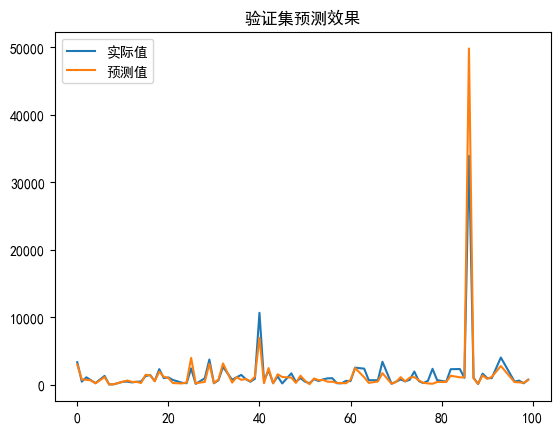

In [51]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

error_df.plot()
plt.title('验证集预测效果')
plt.show()

### 测试集计算

In [52]:
test_pre = gbm.predict(xgboost.DMatrix(flp_test[features]))
test_pre[test_pre < 0] = 0

D:\workspace\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [53]:
test_pre_data_list = [np.exp(x) + 1 for x in test_pre]
test_real_data_list = flp_test['Qty']

In [54]:
# test_pre_data_list  =test_pre
# test_real_data_list = flp_test['Qty']

In [55]:
new_error_df = pd.DataFrame(zip(test_real_data_list, test_pre_data_list))
new_error_df.columns = ['实际值', '预测值']
new_error_df['实际值'] = new_error_df['实际值'].astype(int)
new_error_df['预测值'] = new_error_df['预测值'].astype(int)
new_error_df.index = range(1000, 1096)

In [56]:
# 剔除无实际意义的行(及销量和预测销量均小于30的行)
original_length = new_error_df.shape[0]
new_error_df = new_error_df[(new_error_df['实际值'] > 30)
                            & (new_error_df['预测值'] > 30)]
reject_length = new_error_df.shape[0]
reject_radio = round(
    ((original_length - reject_length) / original_length) * 100, 2)
print(f'剔除了{reject_radio}%的无实际意义数据')

剔除了13.54%的无实际意义数据


## 平均每天销量预测偏差

In [57]:
MAE(test_real_data_list, test_pre_data_list)

285.3630970356365

## 平均每天销量预测准确率

In [58]:
(1 - (abs(new_error_df['实际值'] - new_error_df['预测值']) /
      new_error_df['实际值']).mean()) * 100

58.10760405555301

## 整体预测准确率率

In [59]:
(1 - (abs(new_error_df['实际值'].sum() - new_error_df['预测值'].sum())) /
 new_error_df['实际值'].sum()) * 100

97.23623733025916

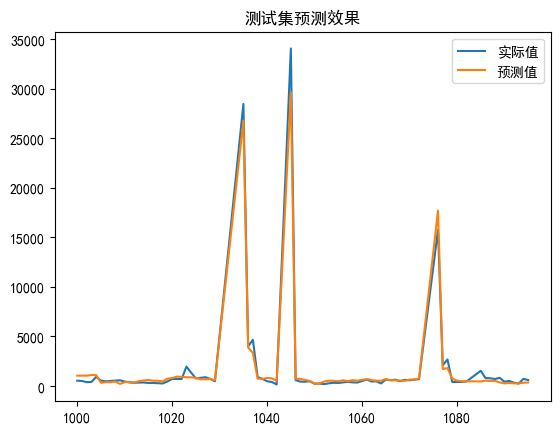

In [60]:
new_error_df.plot()
plt.title('测试集预测效果')
plt.show()

In [61]:
new_error_df['差异'] = abs(new_error_df['预测值'] - new_error_df['实际值'])

new_error_df['差异率'] = abs(new_error_df['预测值'] -
                          new_error_df['实际值']) / new_error_df['实际值']

In [62]:
test_df = pd.merge(flp_test, new_error_df, left_index=True, right_index=True)
test_df.sort_values(by='差异率', ascending=False)

,Date,SKU,Store,Sales,Qty,ASP,客单价,Shopping Cart,宝贝名称,URL地址,...,year,month,day,week,quarter,day_of_week,实际值,预测值,差异,差异率
1042,2021-11-08,0,0,46931,159,295.163522,295.163522,3525.0,313,1,...,2021,11,8,45,4,1,159,537,378,2.377358
1002,2021-09-29,0,0,135543,393,344.895089,382.892006,1480.0,273,1,...,2021,9,29,39,3,3,393,1053,660,1.679389
1003,2021-09-30,0,0,144910,420,345.023810,386.426667,1480.0,274,1,...,2021,9,30,39,3,4,420,1112,692,1.647619
1052,2021-11-18,0,0,70785,195,363.000000,363.000000,3525.0,323,1,...,2021,11,18,46,4,4,195,459,264,1.353846
1001,2021-09-28,0,0,178178,512,348.003906,377.495763,1480.0,272,1,...,2021,9,28,39,3,2,512,1052,540,1.054688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,2021-11-17,0,0,94131,249,378.036145,378.036145,3525.0,322,1,...,2021,11,17,46,4,3,249,258,9,0.036145
1036,2021-11-02,0,0,1121495,4009,279.744480,279.744480,3525.0,307,1,...,2021,11,2,44,4,2,4009,3883,126,0.031429
1071,2021-12-07,0,0,189470,640,296.046875,323.880342,1756.0,342,1,...,2021,12,7,49,4,2,640,657,17,0.026562
1039,2021-11-05,0,0,216161,730,296.112014,296.112014,3525.0,310,1,...,2021,11,5,44,4,5,730,720,10,0.013699


In [63]:
test_df.sort_values(by='差异', ascending=False)

,Date,SKU,Store,Sales,Qty,ASP,客单价,Shopping Cart,宝贝名称,URL地址,...,year,month,day,week,quarter,day_of_week,实际值,预测值,差异,差异率
1045,2021-11-11,0,0,8909256,34044,261.698293,261.698293,3525.0,316,1,...,2021,11,11,45,4,4,34044,29621,4423,0.129920
1076,2021-12-12,0,0,4313514,15757,273.752240,315.407579,1756.0,347,1,...,2021,12,12,49,4,7,15757,17698,1941,0.123183
1035,2021-11-01,0,0,7982268,28450,280.571835,280.571835,3525.0,306,1,...,2021,11,1,44,4,1,28450,26779,1671,0.058735
1037,2021-11-03,0,0,1304223,4663,279.696148,279.696148,3525.0,308,1,...,2021,11,3,44,4,3,4663,3342,1321,0.283294
1023,2021-10-20,0,0,621259,1961,316.807241,355.818442,9818.0,294,1,...,2021,10,20,42,4,3,1961,885,1076,0.548700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,2021-12-29,0,0,78347,253,309.671937,329.189076,1330.0,364,1,...,2021,12,29,52,4,3,253,270,17,0.067194
1012,2021-10-09,0,0,125785,335,375.477612,399.317460,1606.0,283,1,...,2021,10,9,40,4,6,335,351,16,0.047761
1039,2021-11-05,0,0,216161,730,296.112014,296.112014,3525.0,310,1,...,2021,11,5,44,4,5,730,720,10,0.013699
1028,2021-10-25,0,0,228655,725,315.386207,343.325826,3525.0,299,1,...,2021,10,25,43,4,1,725,716,9,0.012414
